Импортируем все необходимые библиотеки

In [1]:
%%capture

import re
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim
import seaborn as sns

from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.decomposition import PCA

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
sns.set_theme(style='whitegrid')

Загрузим предобработанные предложения и словарь

In [2]:
with open('textdata/words.txt', 'r', encoding='utf-8') as words_file:
    words = words_file.read()
words = words.split()

Создадим словарь, а так же двусторонний словарь между словом `token` и его `id` в словаре

In [3]:
def create_dicts(words):
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    id2tok = {ii: word for ii, word in enumerate(sorted_vocab)}
    tok2id = {word: ii for ii, word in id2tok.items()}

    return tok2id, id2tok, len(sorted_vocab)

In [4]:
tok2id, id2tok, vsize = create_dicts(words)
id_words = [tok2id[word] for word in words]
vocab = list(set(words))
word_counts = Counter(words)

Создадим таблицу со словами из словаря и их количеством в тексте

In [5]:
vocab_df = pd.DataFrame({'word': vocab})
vocab_df['id'] = [tok2id[word] for word in vocab]
vocab_df['count'] = [word_counts[word] for word in vocab]
vocab_df.sort_values(by='count', ascending=False, inplace=True)

Итоговое количество слов и размер словаря:

In [6]:
print("Total # of words: {}".format(len(words)))
print("# of unique words: {}".format(len(set(words)))) 

Total # of words: 270168
# of unique words: 5185


Зададим функцию сколзящего окна

In [7]:
def sliding_window(words, wsize=3):
    pairs = []
    
    for i, target in enumerate(words):
        tid = tok2id[target]
            
        start = max(0, i - wsize)
        end = min(len(words), i + wsize + 1)
        for j in range(start, end):
            if (i != j) and (words[j] in vocab):
                cid = tok2id[words[j]]
                pairs.append((tid, cid))
    return pairs

Получим данные для обучения - пары слов (целевое слово, контекстовое слово)

In [8]:
train = sliding_window(words)
        
with open('textdata/train.txt', 'w', encoding='utf-8') as train_file:
        for elem in train:
            line = f"({elem[0]}, {elem[1]})\n"
            train_file.write(line)

Определим свой класс Dataset:

In [9]:
class Word2VecDataset(Dataset):
    def __init__(self, pairs, vsize, wsize=3):
        self.data = pairs
        self.vsize = vsize
        self.wsize = wsize

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
    
word2vec_dataset = Word2VecDataset(train, vsize=vsize)

Напишем свой Dataloader для данных:

In [10]:
BATCH_SIZE = 2**12

dataloader = DataLoader(word2vec_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

print(f"Number of batches: {len(dataloader)}")

Number of batches: 396


Определим класс модели Word2Vec:

In [11]:
class Word2Vec(nn.Module):
    def __init__(self, vsize, esize, noise_dist=None):
        super().__init__()
        
        self.vsize = vsize
        self.esize = esize
        self.noise_dist = noise_dist

        self.in_embed = nn.Embedding(vsize, esize)
        self.out_embed = nn.Embedding(vsize, esize)
        
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward(self, input):
        embed = self.in_embed(input)
        return embed

    def forward_input(self, input_vectors):
        input_embeddings = self.in_embed(input_vectors)
        return input_embeddings

    def forward_target(self, output_vectors):
        output_embeddings = self.out_embed(output_vectors)
        return output_embeddings

    def forward_noise(self, batch_size, n_samples=5):
        '''Генерация шумовых векторов для negative sampling из шумового распределения'''
        if self.noise_dist is None:
            noise_dist = torch.ones(self.vsize)
        else:
            noise_dist = self.noise_dist

        noise_words = torch.multinomial(input=noise_dist,
                                        num_samples=batch_size*n_samples, replacement=True)
        noise_words = noise_words.to(device)

        noise_vectors = self.out_embed(noise_words).view(
            batch_size, n_samples, self.esize)

        return noise_vectors

Определим Loss-функцию с поддержкой негативных сэмплов:

In [12]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
      
        batch_size, embed_size = input_vectors.shape
    
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
    
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()
    
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)

        return -(out_loss + noise_loss).mean()

Определим распределение шума по формуле:
$$
P_{n}(w) = \frac{U(w)^{\frac{3}{4}}}{Z}
$$

In [13]:
freq = Counter(id_words)
freq_ratio = {word:cnt/len(tok2id) for word, cnt in freq.items()}        
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum() 
noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

Создадим модель

In [21]:
EMBED_SIZE = 128
LR = 1e-3
NEG_SAMPLES = 10

model = Word2Vec(vsize, EMBED_SIZE, noise_dist).to(device)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = LR)
print(model, f"Running on: {device}", sep='\n')

Word2Vec(
  (in_embed): Embedding(5185, 128)
  (out_embed): Embedding(5185, 128)
)
Running on: cuda


Обучим модель

In [22]:
total_epochs = 0
running_loss = []

  0%|          | 0/39600 [00:00<?, ?it/s]

Current model epoch: 100


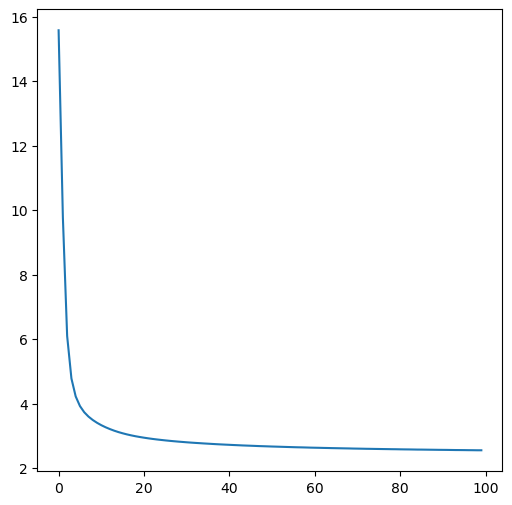

In [23]:
EPOCHS = 100
total_epochs += EPOCHS
progress_bar = tqdm(range(EPOCHS * len(dataloader)))

for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for tw, cw in dataloader:
        tw, cw = tw.to(device), cw.to(device)
        
        in_embed = model.forward_input(tw)
        out_embed = model.forward_target(cw)
        noise = model.forward_noise(batch_size=tw.shape[0], 
                                                  n_samples=NEG_SAMPLES)

        loss = criterion(in_embed, out_embed, noise)
        epoch_loss += loss.detach().cpu()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.update(1)
        
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)
    
print(f"Current model epoch: {total_epochs}")

plt.figure(figsize = (6, 6))
plt.plot(running_loss)
if (total_epochs > EPOCHS):
    plt.axvline(x = (total_epochs - EPOCHS), color='g', label='previous loss')
plt.show()

Сохранение модели

In [24]:
PATH = f"model/word2vec-ViM-vsize{vsize}-ep{total_epochs}-emb{EMBED_SIZE}-neg{NEG_SAMPLES}.checkpoint"

torch.save({
            'epoch': total_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

Загрузка модели

In [12]:
#model = Word2Vec(vsize, EMBED_SIZE).to(device)
#checkpoint = torch.load('model/word2vec-ViM-vsize5875-ep1500-emb128.checkpoint')
#model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Выгрузим вектроные репрезентации слов

In [25]:
wordvecs = model.in_embed.weight.cpu().detach().numpy()

Зададим матрицу расстояний с косинусной метрикой и определим функцию ближайших слов для одного и для алгебраической суммы слов

In [272]:
def get_embed(wordvecs, word):
    return wordvecs[tok2id[word]]

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=7):
    dists = dist_matrix[tok2id[word]]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

def get_k_similar_words_for_sum(pos=[], neg=[], k=7):
    mean = np.zeros((EMBED_SIZE,), dtype=float)
    for word in pos:
        mean += wordvecs[tok2id[word]]
    for word in neg:
        mean -= wordvecs[tok2id[word]]
    mean /= (len(pos) + len(neg))
    
    dists = np.zeros((vsize,), dtype=float)
    for i, vec in enumerate(wordvecs):
        dists[i] = distance.cosine(mean, vec)

    ind = np.argpartition(dists, k)[:(k+len(pos))]
    ind = ind[np.argsort(dists[ind])][len(pos):]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out   

dmat = get_distance_matrix(wordvecs, 'cosine')